# Questrade Portfolio Manager

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from qtrade import Questrade as qt
#from questrade_api import Questrade

## Authentication to Questrade API

In [2]:
try:
    qtrade = qt(token_yaml='access_token.yml')
except:
    code = open("access_code.txt", "r").read()
    qtrade = qt(access_code=code)

In [3]:
try:
    acctId = qtrade.get_account_id()
except:
    qtrade.refresh_access_token(from_yaml=True)
    acctId = qtrade.get_account_id()

In [4]:
acctId

['51802566']

## Portfolio Status

In [5]:
position_data = {
    'Symbol': [],
    'Description': [],
    'Quantities': [],
    'Market Value': [],
    'Gain/Loss (%)': []
}
total_costs = 0
total_market_value = 0
for account in acctId:
    positions = qtrade.get_account_positions(account)
    for position in positions:
        symbol = position['symbol']
        description = qtrade.ticker_information(symbol)['description']
        qty = position['openQuantity']
        cmv = position['currentMarketValue']
        #cmv_str = '$ ' + str(cmv)
        cost = position['totalCost']
        change = round(100 * (cmv - cost) / cost, 2)
        change_str = str(change) + ' %'

        total_market_value = total_market_value + cmv
        total_costs = total_costs + cost
        position_data['Symbol'].append(symbol)
        position_data['Description'].append(description)
        position_data['Quantities'].append(qty)
        position_data['Market Value'].append(cmv)
        position_data['Gain/Loss (%)'].append(change_str)

In [6]:
portfolio = pd.DataFrame(position_data)
portfolio.set_index('Symbol', inplace=True)
portfolio

,Description,Quantities,Market Value,Gain/Loss (%)
Symbol,,,,
O,REALTY INCOME CORP,75,4819.50,5.0 %
VTI,VANGUARD INDEX FUNDS VANGUARD TOTAL STOCK MARK...,3,617.94,5.26 %
QQQ,INVESCO QQQ TRUST UNIT SER 1,2,633.24,-0.96 %
GLD,SPDR GOLD TRUST GOLD SHARES NPV,7,1123.64,-7.91 %
TLT,ISHARES TRUST BARCLAYS 20+ TREAS BD FD TO 07/0...,4,542.96,-10.5 %
IEF,ISHARES TRUST BARCLAYS 7-10 YEAR TREASURY BOND...,5,566.50,-4.5 %


In [7]:
portfolio['%Portfolio'] = [
    round(100 * (x / total_market_value), 2) for x in portfolio['Market Value']
]

<AxesSubplot:title={'center':'Portfolio Breakdown'}, ylabel='%Portfolio'>

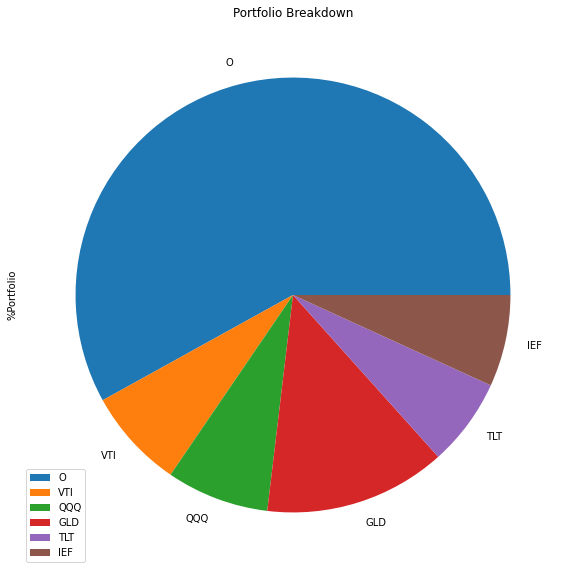

In [8]:
portfolio['%Portfolio'].plot(kind='pie',
                             title='Portfolio Breakdown',
                             figsize=(10, 10),
                             legend=True)

## Monthly Dividend Income

In [9]:
startDate = '2018-04-01'
endDate = dt.date.today().strftime("%Y-%m-%d")
dtrange = pd.date_range(startDate, endDate, freq='d')
months = pd.Series(dtrange.month)
starts, ends = months.ne(months.shift(1)), months.ne(months.shift(-1))
startEndDates = pd.DataFrame({
    'month_starting_date':
    dtrange[starts].strftime('%Y-%m-%d'),
    'month_ending_date':
    dtrange[ends].strftime('%Y-%m-%d')
})
dateList = startEndDates.values.tolist()

In [10]:
output = {}
total_div_earned = 0

for date in dateList:
    start = date[0]
    end = date[1]
    activities = qtrade.get_account_activities(acctId[0], start, end)
    monthly_div = 0
    for activity in activities:
        if activity['type'] == 'Dividends':
            monthly_div = monthly_div + activity['netAmount']
    output[dt.datetime.strptime(start,
                                "%Y-%m-%d").strftime("%Y-%m")] = monthly_div
    total_div_earned = total_div_earned + monthly_div

In [11]:
monthly_div_df = pd.DataFrame.from_dict(output,
                                        orient='index',
                                        columns=['Monthly_Dividend_Income'])

## Dividend Income History with Bar Chart Visualization

<AxesSubplot:title={'center':'Monthly Dividend Payments'}, xlabel='Months', ylabel='Dividend ($)'>

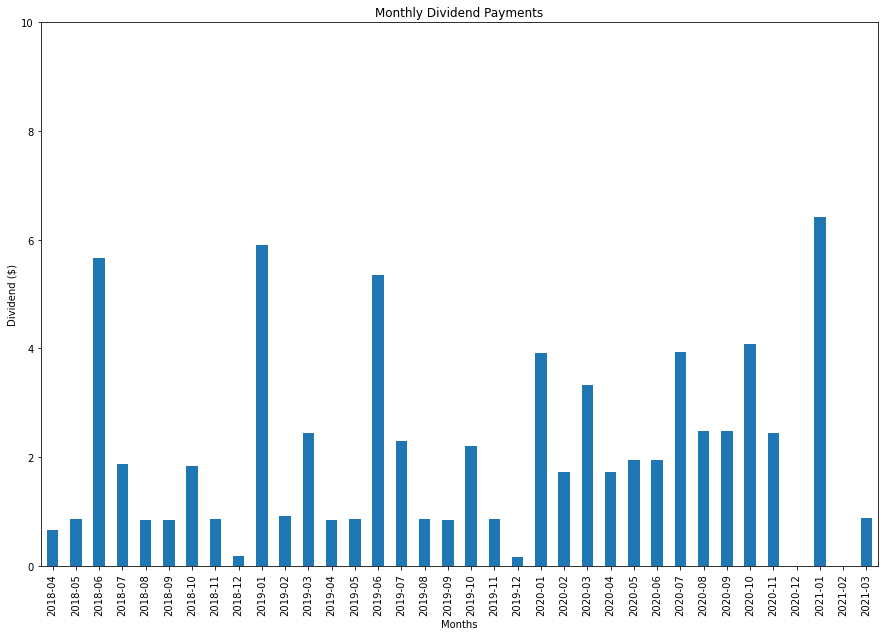

In [12]:
monthly_div_df.plot(kind='bar',
                    title='Monthly Dividend Payments',
                    xlabel='Months',
                    ylabel='Dividend ($)',
                    figsize=(15, 10),
                    legend=False,
                    ylim=(0, 10))

## Portfolio Summary

In [13]:
summary = {'Portfolio Return (%)': [], 'Total Dividend Earned ($)': []}
summary['Portfolio Return (%)'].append(
    100 * (total_market_value - total_costs) / total_costs)
summary['Total Dividend Earned ($)'].append(total_div_earned)
summary_df = pd.DataFrame(summary)
summary_df

,Portfolio Return (%),Total Dividend Earned ($)
0,0.81837,74.53
